# 1. Install and import the game and other dependencies

In [1]:
%pip install nes-py
%pip install gym-super-mario-bros==7.3.0
%pip install setuptools==65.5.0 "wheel<0.40.0"
%pip install gym==0.21.0
%pip install stable-baselines3[extra]==1.6.0

Note: you may need to restart the kernel to use updated packages.
  Using cached gym_super_mario_bros-7.3.0-py2.py3-none-any.whl.metadata (9.4 kB)
Using cached gym_super_mario_bros-7.3.0-py2.py3-none-any.whl (198 kB)
  Attempting uninstall: gym-super-mario-bros
    Found existing installation: gym-super-mario-bros 7.4.0
    Uninstalling gym-super-mario-bros-7.4.0:
      Successfully uninstalled gym-super-mario-bros-7.4.0
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [3]:
%pip install chardet

   ---------------------------------------- 0.0/199.4 kB ? eta -:--:--
   ------ -------------------------------- 30.7/199.4 kB 660.6 kB/s eta 0:00:01
   ---------------- ---------------------- 81.9/199.4 kB 770.8 kB/s eta 0:00:01
   ---------------------------------- ----- 174.1/199.4 kB 1.3 MB/s eta 0:00:01
   ---------------------------------------- 199.4/199.4 kB 1.2 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [1]:
#Import the super mario game in the notebook
import gym_super_mario_bros

#Import the Joypad wrapper in the notebook
from nes_py.wrappers import JoypadSpace

#Import the simple controls so that the model just needs to control some movements of our agent (here Mario)
from gym_super_mario_bros.actions import SIMPLE_MOVEMENT


In [2]:
#Changes the game from colour image (RGB) to grayscale so that our processing becomes faster as we need to deal with less data 
from gym.wrappers import GrayScaleObservation, ResizeObservation   

#VecFrameStack allows us to work with our stacked enviroments by letting us know the information of previous frames. DummyVecEnv transforms our model so that we can pass it to our AI model. 
from stable_baselines3.common.vec_env import VecFrameStack, SubprocVecEnv, VecMonitor, VecNormalize

# 2. Preprocessing the environment

In [3]:
import gym
from gym.spaces import Box
import numpy as np


class SkipWrapper(gym.ObservationWrapper):
    def __init__(self, env, n_stack=4, n_skip=2):
        super().__init__(env)
        self.n_stack = n_stack
        self.n_skip = n_skip
        self.height = 84
        self.width = 84

        self.observation_space = Box(
            low=0, high=255, shape=(self.height, self.width, self.n_stack), dtype=np.uint8
        )
        self.frame_stack = np.zeros((self.height, self.width, (self.n_stack-1)*self.n_skip+1), dtype=np.uint8)

    def observation(self, obs):
        self.frame_stack[:,:,1:] = self.frame_stack[:,:,:-1] # shift frame_stack by 1
        self.frame_stack[:,:,0] = obs[:,:,0] # add current frame to stack
        obs = self.frame_stack[:,:,::self.n_skip]
        return obs

    def reset(self):
        obs = self.env.reset()
        obs = obs[:,:,0]
        self.frame_stack = np.zeros((self.height, self.width, (self.n_stack-1)*self.n_skip+1), dtype=np.uint8)
        for i in range(self.frame_stack.shape[-1]):
            self.frame_stack[:,:,i] = obs
        obs = self.frame_stack[:,:,::self.n_skip]
        return obs

In [4]:
env = gym_super_mario_bros.make("SuperMarioBros-1-1-v0")
env.observation_space

Box([[[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 ...

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]], [[[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 ...

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
 

In [5]:
env = gym_super_mario_bros.make("SuperMarioBros-1-1-v0")
env = JoypadSpace(env, SIMPLE_MOVEMENT)
env = GrayScaleObservation(env, keep_dim=True)
env = ResizeObservation(env, (84, 84))

In [6]:
state = env.reset()

In [7]:
state.shape

(84, 84, 1)

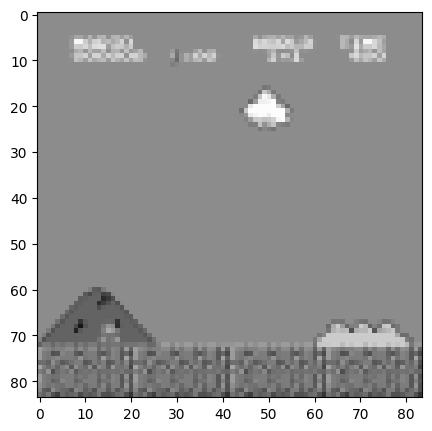

In [8]:
from matplotlib import pyplot as plt
import cv2

n_stack=1

fig, ax = plt.subplots(1, n_stack, figsize=(7,5))
for i in range(n_stack):
    obs = state[:,:,i]
    obs = cv2.cvtColor(obs, cv2.COLOR_BGR2RGB)
    ax.imshow(obs)
plt.show()

In [9]:
env = gym_super_mario_bros.make("SuperMarioBros-1-1-v0")
env = JoypadSpace(env, SIMPLE_MOVEMENT)
env = GrayScaleObservation(env, keep_dim=True)
env = ResizeObservation(env, (84, 84))
env = SkipWrapper(env, n_stack=4, n_skip=4)

In [10]:
from stable_baselines3.common.env_checker import check_env

check_env(env)

In [11]:
#Location of trained and logged files 
CHECKPOINT_DIR = './train/WithoutSkipWrapper'
LOG_DIR = './logs'
HPO_LOG_DIR = './opt_logs'
HPO_CHECKPOINT_DIR = './opt_train'

In [12]:
def make_env(seed, env_name):
    def init():
        env = gym_super_mario_bros.make(env_name)
        env = JoypadSpace(env, SIMPLE_MOVEMENT)
        env = GrayScaleObservation(env, keep_dim=True)
        env = ResizeObservation(env, (84, 84))
        env.seed(seed)

        return env
    return init

In [14]:
env = SubprocVecEnv([make_env(i, "SuperMarioBros-1-1-v0") for i in range(6)])
env = VecMonitor(env, "./logs")
env = VecNormalize(env, clip_obs=255, clip_reward=15)
env = VecFrameStack(env, 4, channels_order="last")

In [15]:
env.observation_space.shape

(84, 84, 4)

In [16]:
SIMPLE_MOVEMENT

[['NOOP'],
 ['right'],
 ['right', 'A'],
 ['right', 'B'],
 ['right', 'A', 'B'],
 ['A'],
 ['left']]

# 3. Hyperparameter Tuning

In [17]:
# Importing the optimization frame - HPO
# import optuna
# Bring in the eval policy method for metric calculation
from stable_baselines3.common.evaluation import evaluate_policy
import gc
# Import os for file path management
import os

# Import PPO algorithm to train our model
from stable_baselines3 import PPO

# Import Base Callback for saving models and to continue from there
from stable_baselines3.common.callbacks import BaseCallback

In [18]:
# Function to return test hyperparameters - define the object function

def optimize_ppo(trial):
    return {
        'batch_size': trial.suggest_categorical("batch_size", [8, 16, 32, 64, 128, 256, 512]),
        'n_steps': trial.suggest_categorical("n_steps", [512, 1024, 2048, 4096]), # 
        'gamma': trial.suggest_float("gamma", 0.8, 0.999, log=True),
        'learning_rate': trial.suggest_float("learning_rate", 5e-6, 0.001, log=True),
        'ent_coef': trial.suggest_float("ent_coef", 0.0001, 0.1, log=True),
        'clip_range': trial.suggest_categorical("clip_range", [0.1, 0.2, 0.3]),
        'n_epochs': trial.suggest_int("n_epochs", 1, 10),
        'gae_lambda': trial.suggest_float("gae_lambda", 0.8, 1, log=True),
        'max_grad_norm': trial.suggest_categorical("max_grad_norm", [0.3, 0.5, 0.6, 0.7, 0.8, 0.9, 1, 2, 5]),
        'vf_coef': trial.suggest_float("vf_coef", 0.001, 1)
    }

In [ ]:
def optimize_agent(trial):
    try:
        model_params = optimize_ppo(trial)
        
        env = SubprocVecEnv([make_env(i) for i in range(6)])
        env = VecMonitor(env, "./opt_logs")
        env = VecNormalize(env, clip_obs=255, clip_reward=15)
        env = VecFrameStack(env, 4, channels_order="last")
        
        # Create PPO
        model = PPO('CnnPolicy', env, tensorboard_log='./opt_logs', verbose=0, **model_params)
        model.learn(total_timesteps=500000)

        # Evaluate model
        mean_reward, _ = evaluate_policy(model, env, n_eval_episodes=6)

        SAVE_PATH = os.path.join('./opt_train', 'trial_{}_best_model'.format(trial.number))
        model.save(SAVE_PATH)

        env.close()

        gc.collect()

        return mean_reward
    
    except Exception as e:
        return e

In [ ]:
study = optuna.create_study(direction='maximize')
study.optimize(optimize_agent, n_trials=100, n_jobs=1)

[I 2024-04-27 10:17:00,835] A new study created in memory with name: no-name-1bed4b09-223c-4c4e-bcfd-7a5700b62b32
[I 2024-04-27 11:14:32,391] Trial 0 finished with value: 652.0 and parameters: {'batch_size': 512, 'n_steps': 4096, 'gamma': 0.9883036470196476, 'learning_rate': 8.248052180662126e-05, 'ent_coef': 0.0033192103311894183, 'clip_range': 0.3, 'n_epochs': 5, 'gae_lambda': 0.8919467930908171, 'max_grad_norm': 0.7, 'vf_coef': 0.7984597981165633}. Best is trial 0 with value: 652.0.
[I 2024-04-27 12:02:37,900] Trial 1 finished with value: 1412.0 and parameters: {'batch_size': 32, 'n_steps': 512, 'gamma': 0.9338680619365152, 'learning_rate': 0.0001268588513340457, 'ent_coef': 0.0009831640718997235, 'clip_range': 0.3, 'n_epochs': 6, 'gae_lambda': 0.8439412903910558, 'max_grad_norm': 0.7, 'vf_coef': 0.22397706946296733}. Best is trial 1 with value: 1412.0.
[I 2024-04-27 12:31:02,059] Trial 2 finished with value: 680.0 and parameters: {'batch_size': 32, 'n_steps': 4096, 'gamma': 0.96430

# 4. Build and Train the RL Model

##### To train our RL model(Our AI) we are going to use PPO (Proximal Policy Optimization) Algorithm. 

In [19]:
#Set the clipping range
def custom_clip_range(a):
    a = 0.2
    return a  

#Set the learning rate
def linear_schedule(initial_value: float):
    """
    Linear learning rate schedule.

    :param initial_value: Initial learning rate.
    :return: schedule that computes
      current learning rate depending on remaining progress
    """
    def func(progress_remaining: float) -> float:
        """
        Progress will decrease from 1 (beginning) to 0.

        :param progress_remaining:
        :return: current learning rate
        """
        return progress_remaining * initial_value

    return func

In [20]:
#Specify the trainnig files and logging files location
class TrainAndLoggingCallback(BaseCallback):
    def __init__(self, check_freq, save_path, verbose=1):
        super(TrainAndLoggingCallback, self).__init__(verbose)
        self.check_freq = check_freq
        self.save_path = save_path

    def _init_callback(self):
        if self.save_path is not None:
            os.makedirs(self.save_path, exist_ok=True)

    def _on_step(self):
        # Save the model and track training progress
        if self.num_timesteps % self.check_freq == 0:
            model_path = os.path.join(self.save_path, 'best_model_{}'.format(self.num_timesteps))
            self.model.save(model_path)

        return True

In [21]:
model_params = { 
    'batch_size': 256,
    'n_steps': 4096,
    'gamma': 0.99, 
    'learning_rate': linear_schedule(5e-4),
    'ent_coef': 0,
    'clip_range': 0.2,
    'n_epochs': 5, 
    'gae_lambda': 0.95, 
    'max_grad_norm': 0.5, 
    'vf_coef': 0.5
}

In [22]:
#model = PPO.load(os.path.join(CHECKPOINT_DIR, 'best_model_2000040'), env, tensorboard_log=LOG_DIR)
model = PPO('CnnPolicy', env, tensorboard_log='./logs/WithoutSkipWrapper/linear_learning_rate', verbose=0, **model_params)

In [23]:
model.batch_size

256

In [24]:
#Location of trained and logged files 
CHECKPOINT_DIR = './train/WithoutSkipWrapper/linear_learning/model_3'
LOG_DIR = './logs'
HPO_LOG_DIR = './opt_logs'
HPO_CHECKPOINT_DIR = './opt_train'

In [25]:
# Call back the trained and logged model after every 100002 steps (takes 150MB space for one run logged data for 5k steps) and save to CHECKPOINT_DIR.
callback = TrainAndLoggingCallback(check_freq=100002, save_path=CHECKPOINT_DIR)

In [25]:
# model.learning_rate = 1e-05

In [26]:
model = PPO.load(os.path.join(CHECKPOINT_DIR, 'best_model_1200024'), env)

FileNotFoundError: [Errno 2] No such file or directory: 'train\\WithoutSkipWrapper\\linear_learning\\model_3\\best_model_1200024.zip'

In [26]:
model.num_timesteps

0

In [27]:
model.learn(total_timesteps=5e6, callback=callback, tb_log_name="model_3")

: 

# 4. Testing the model (AI)

In [ ]:
# Load the new combined model
combined_model = PPO.load('./train/best_model_200000', custom_objects={'clip_range': custom_clip_range, 'learning_rate': linear_schedule(0.0001)})

: 

In [ ]:
#Starting our game
state = env.reset()

#Loop through the game
while True:
    # we are getting two values of which we need only one, so we put a underscore to just assign it the extra value
    action, _ = combined_model.predict(state)
    state, reward, done, info = env.step(action)
    env.render()

: 

To stop the loop, that is the game, press the "interrupt the kernel" button shown by a black square next to "Run"

In [ ]:
#To close the game environment
env.close()

: 